## 1. Business Understanding

This project will analyze customer reviews of Amazon's electronic products to identify the key drivers of customer satisfaction and dissatisfaction. By understanding what customers love and hate about our products, we can provide actionable insights to:

*   **Product Development:** Pinpoint specific features that need improvement and identify new features that customers desire.
*   **Marketing:** Craft more effective marketing messages that highlight the features customers love the most.
*   **Quality Assurance:** Identify products with recurring quality issues.

The ultimate goal is to improve product quality, increase customer satisfaction, and boost sales.

## 2. Data Understanding

I chose to use [Consumer Reviews of Amazon Products](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products) from Kaggle because it contains a lot of the review from the customers. It also contain some important featues, such as categories of the product, manufaturer of the product and the rating, which is really helpful for sentiment analytics and further exploration. Unfortunately, after exaim this dataset, it only contains review which related to technical product, and only include the product manufacture by Amazon, I think it'll be the biggest hindrance when using this dataset for analyze

In [3]:
import kagglehub
import pandas as pd
import os
import re
from nltk.corpus import stopwords
from collections import Counter

import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
df1 = pd.read_csv(os.path.join(path, '1429_1.csv'), low_memory=False)
df2 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))
df3 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'))

The original dataset from Kaggle be divided to three sperate csv file, after concate it, it include the following features and information. Here is a quick overview:

In [5]:
master_df = pd.concat([df1, df2, df3], ignore_index=True)
master_df.to_csv('amazon_reviews_master.csv')
master_df.info()
master_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   name                  61232 non-null  object 
 2   asins                 67990 non-null  object 
 3   brand                 67992 non-null  object 
 4   categories            67992 non-null  object 
 5   keys                  67992 non-null  object 
 6   manufacturer          67992 non-null  object 
 7   reviews.date          67953 non-null  object 
 8   reviews.dateAdded     25091 non-null  object 
 9   reviews.dateSeen      67992 non-null  object 
 10  reviews.didPurchase   10 non-null     object 
 11  reviews.doRecommend   55152 non-null  object 
 12  reviews.id            71 non-null     float64
 13  reviews.numHelpful    55246 non-null  float64
 14  reviews.rating        67959 non-null  float64
 15  reviews.sourceURLs 

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       42901
reviews.dateSeen            0
reviews.didPurchase     67982
reviews.doRecommend     12840
reviews.id              67921
reviews.numHelpful      12746
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title              19
reviews.userCity        67992
reviews.userProvince    67992
reviews.username           13
dateAdded               34660
dateUpdated             34660
primaryCategories       34660
imageURLs               34660
manufacturerNumber      34660
sourceURLs              34660
dtype: int64

We can see all the columns and their missing values in the result above

### 3. Data Preparation & Exploratory Data Analysis (EDA)

In [6]:
master_df.isna().sum()
master_df.duplicated().sum()

np.int64(95)

#### - Drop unrelated features and duplicate values

In [7]:
df_cleaned = master_df.copy()

In [8]:
df_cleaned.drop_duplicates(subset=['reviews.username', 'reviews.text', 'reviews.rating'], inplace=True)

In [9]:
# Define the columns to drop
columns_to_drop = [
    'reviews.userCity',
    'reviews.userProvince',
    'reviews.id',
    'reviews.didPurchase',
    'reviews.dateAdded',
    'id',
    'asins',
    'keys',
    'manufacturer',
    'reviews.sourceURLs',
    'sourceURLs',
    'imageURLs',
    'manufacturerNumber',
    'dateAdded',
    'dateUpdated'
]

df_cleaned.drop(columns=columns_to_drop, inplace=True)

#### - Drop missing value & chage the data type

In [10]:
# Drop rows where essential data is missing
df_cleaned.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'reviews.date', 'reviews.doRecommend'], inplace=True)
df_cleaned['primaryCategories'] = df_cleaned['primaryCategories'].fillna('Unknown')
df_cleaned['name'] = df_cleaned['name'].fillna('Unknown')
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'], errors='coerce')
df_cleaned['reviews.rating'] = df_cleaned['reviews.rating'].astype(int)
df_cleaned['reviews.numHelpful'] = df_cleaned['reviews.numHelpful'].fillna(0).astype(int)


df_cleaned.info()
df_cleaned.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 37297 entries, 0 to 66412
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   name                 37297 non-null  object             
 1   brand                37297 non-null  object             
 2   categories           37297 non-null  object             
 3   reviews.date         37297 non-null  datetime64[ns, UTC]
 4   reviews.dateSeen     37297 non-null  object             
 5   reviews.doRecommend  37297 non-null  object             
 6   reviews.numHelpful   37297 non-null  int64              
 7   reviews.rating       37297 non-null  int64              
 8   reviews.text         37297 non-null  object             
 9   reviews.title        37297 non-null  object             
 10  reviews.username     37297 non-null  object             
 11  primaryCategories    37297 non-null  object             
dtypes: datetime64[ns, UTC](

name                   0
brand                  0
categories             0
reviews.date           0
reviews.dateSeen       0
reviews.doRecommend    0
reviews.numHelpful     0
reviews.rating         0
reviews.text           0
reviews.title          0
reviews.username       0
primaryCategories      0
dtype: int64

#### - Review text Cleaning for sentiment analyze

In [11]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_cleaned['reviews.text_cleaned'] = df_cleaned['reviews.text'].apply(clean_text)
df_cleaned['reviews.title_cleaned'] = df_cleaned['reviews.title'].apply(clean_text)

#### - Fig1. Distribution of Customer Ratings

In [12]:
rating_counts = Counter(df_cleaned['reviews.rating'])
ratings = sorted(rating_counts.keys())
counts = [rating_counts[rating] for rating in ratings]

fig1 = go.Figure(data=[go.Bar(x=ratings, y=counts)])

fig1.update_layout(
    title='Distribution of Customer Ratings',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews',
    xaxis=dict(tickmode='linear')
)

fig1.show()

- The first chart shows that almost everyone loves these products. The bar for 5-star reviews is huge (over 25,000!), way more than all the other ratings combined.

- This shows that, in general, customers are super happy. But it also means I should probably pay extra attention to the few 1-star and 2-star reviews, since they're so different from the norm.

#### Fig2. Average Customer Rating Over Time

In [13]:
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'])

df_cleaned['month_year'] = df_cleaned['reviews.date'].dt.tz_localize(None).dt.to_period('M')
monthly_ratings = df_cleaned.groupby('month_year')['reviews.rating'].mean().reset_index()
monthly_ratings = monthly_ratings.sort_values('month_year')

monthly_ratings['month_year'] = monthly_ratings['month_year'].dt.to_timestamp()

fig2 = go.Figure(data=[go.Scatter(x=monthly_ratings['month_year'], y=monthly_ratings['reviews.rating'], mode='lines+markers')])

fig2.update_layout(
    title='Average Customer Rating Over Time',
    xaxis_title='Date',
    yaxis_title='Average Rating'
)

fig2.show()

- Overall, average customer ratings remain high, consistently staying above 4.3 stars. This reinforces our finding that most customers are highly satisfied.

- There was a severe drop in customer satisfaction in the second half of 2015, with average ratings plummeting from 4.8 to below 4.4. This is a major red flag. This trend reversed in early 2016, followed by a slow, steady 2-year recovery.

- We see a massive spike in satisfaction in mid-2018, with ratings hitting a perfect 5.0 before becoming more volatile. This spike likely corresponds to a very successful new product launch.

#### Fig3. WordClound of Reviews

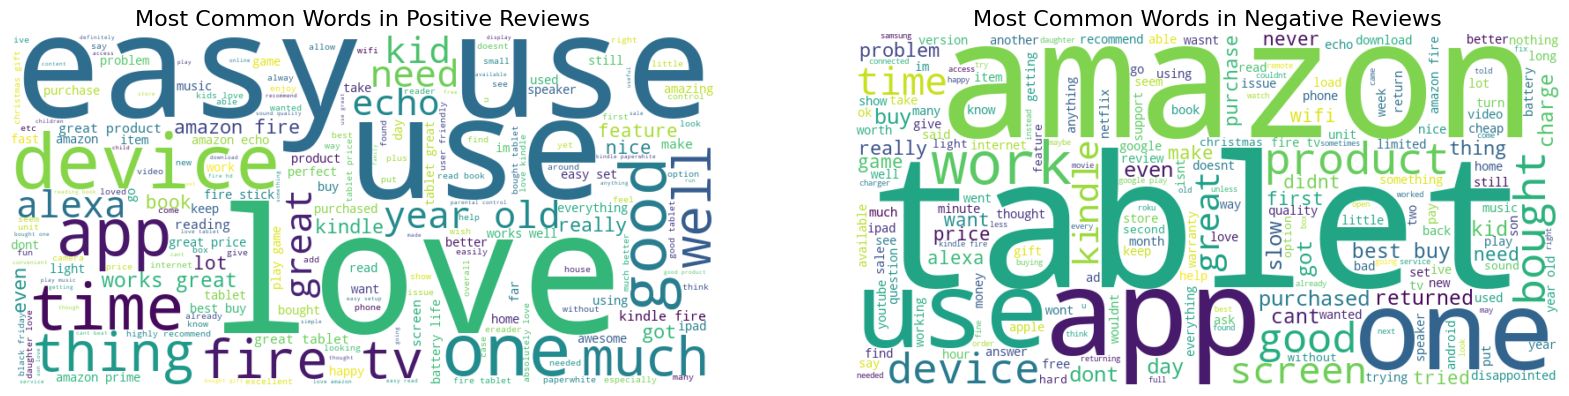

In [14]:

positive_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([4, 5])]['reviews.text_cleaned']
negative_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([1, 2])]['reviews.text_cleaned']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=400, background_color='white'
).generate(positive_text)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white'
).generate(negative_text)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews', fontsize=16)
plt.axis('off')

plt.show()

- In Positive Reviews: The biggest words are love, easy, use, and device.

- In Negative Reviews: The word tablet is massive. Other big words are app, problem, and work.

- It looks like people are happiest when the product is just easy to use. The negative reviews suggest that the tablets are the main source of problems, probably related to apps not working right or the device itself breaking.

#### Fig4. Average "Helpful" Votes by Star Rating

In [15]:
helpfulness_by_rating = df_cleaned.groupby('reviews.rating')['reviews.numHelpful'].mean().reset_index()

fig4 = go.Figure(data=[
    go.Bar(
        x=helpfulness_by_rating['reviews.rating'],
        y=helpfulness_by_rating['reviews.numHelpful']
    )
])

fig4.update_layout(
    title='Average "Helpful" Votes by Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Average "Helpful" Votes'
)

fig4.show()

- This chart was really surprising. 1-star reviews get an average of 1.75 "helpful" votes, which is way more than any other rating. 2-star reviews are the second most helpful.

- This shows that people actually find the negative reviews more helpful when they're deciding what to buy. It's a big deal because it means the company should really be reading and replying to those 1-star reviews.

#### Fig5. Review Length vs. Star Rating

In [16]:
df_cleaned['review_length'] = df_cleaned['reviews.text'].str.len()

fig5 = go.Figure(data=[
    go.Box(
        x=df_cleaned['reviews.rating'],
        y=df_cleaned['review_length']
    )
])

# 3. Manually set the titles and labels
fig5.update_layout(
    title='Review Length vs. Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Length of Review (Characters)'
)

# 4. Your y-axis update is the same
fig5.update_yaxes(range=[0, 2000])

fig5.show()

- I made a boxplot to see if angry people write more, and they do. The "box" for 1-star and 2-star reviews is higher up, meaning their typical review length is longer than for 3, 4, or 5-star reviews.

- Those dots are outliers (some people write a lot), but the main takeaway is that negative reviews are usually more detailed. People aren't just saying "it's bad"; they're explaining why it's bad, which is really useful data for the company to find and fix bugs.

## 4. Modeling

In [17]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [18]:
# Create a new dataframe for modeling, dropping the 3-star reviews (too less of data)
df_model = df_cleaned[df_cleaned['reviews.rating'] != 3].copy()
df_model['sentiment'] = df_model['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)
X = df_model['reviews.text_cleaned']
y = df_model['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Test for deep learning model

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Define tokenizer parameters
MAX_VOCAB_SIZE = 10000  # How many unique words to use
MAX_LENGTH = 200        # Max length of a review (in words)
EMBEDDING_DIM = 100     # Dimension of the word vectors

# 2. Create the tokenizer and fit it on the training text
# This learns the "vocabulary"
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 3. Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 4. Pad the sequences so they're all the same length
# LSTMs require fixed-length inputs
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [20]:
model = Sequential([
    # 1. Embedding Layer: Turns word IDs into dense vectors
    # This is the "meaning space"
    Embedding(input_dim=MAX_VOCAB_SIZE,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_LENGTH),
    
    # 2. LSTM Layer: The "memory" cell that reads the sequence
    # Bidirectional means it reads the review left-to-right AND right-to-left
    # for even more context.
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)), # A second LSTM layer for deeper processing
    
    # 3. Dropout Layer: Prevents the model from "memorizing"
    Dropout(0.5),
    
    # 4. Output Layer: A final neuron that makes the 0 or 1 decision
    Dense(1, activation='sigmoid') # Sigmoid squashes the output between 0 and 1
])

# Get a summary of your model's architecture
model.summary()

/opt/miniconda3/envs/CDA/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 1. Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 2. Calculate class weights to handle imbalance
# (Same logic as before, just a different format)
total = len(y_train)
pos = np.sum(y_train)
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for 0 (Negative): {weight_for_0}")
print(f"Weight for 1 (Positive): {weight_for_1}")

# 3. Train the model!
# This will take a few minutes
NUM_EPOCHS = 5
BATCH_SIZE = 64

history = model.fit(X_train_padded, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights) # <-- This is critical!

Weight for 0 (Negative): 22.353677621283257
Weight for 1 (Positive): 0.5114397221526013
Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 88s 193ms/step - accuracy: 0.7509 - loss: 0.5142 - val_accuracy: 0.8015 - val_loss: 0.4754
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 99s 222ms/step - accuracy: 0.9207 - loss: 0.2515 - val_accuracy: 0.9597 - val_loss: 0.1570
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 97s 217ms/step - accuracy: 0.9565 - loss: 0.1688 - val_accuracy: 0.9579 - val_loss: 0.1451
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 97s 217ms/step - accuracy: 0.9655 - loss: 0.1258 - val_accuracy: 0.9451 - val_loss: 0.1610
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 92s 206ms/step - accuracy: 0.9713 - loss: 0.1073 - val_accuracy: 0.9524 - val_loss: 0.1417


224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step

--- LSTM Model Final Report ---
              precision    recall  f1-score   support

           0       0.26      0.60      0.36       160
           1       0.99      0.96      0.98      6982

    accuracy                           0.95      7142
   macro avg       0.62      0.78      0.67      7142
weighted avg       0.97      0.95      0.96      7142



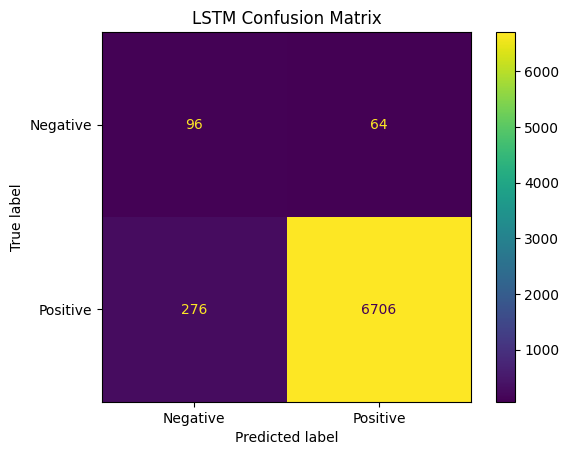

In [22]:
# 1. Get predictions (as probabilities)
y_pred_probs = model.predict(X_test_padded)

# 2. Round the probabilities to get class labels
y_pred_lstm = np.where(y_pred_probs > 0.5, 1, 0)

# 3. Print the final report!
print("\n--- LSTM Model Final Report ---")
print(classification_report(y_test, y_pred_lstm))

# 4. Plot the confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Negative', 'Positive'])
disp_lstm.plot()
plt.title('LSTM Confusion Matrix')
plt.show()

## 5. Evaluation

Technical:

- The Logistic Regression model has better performance with 70% of recall score, indicating that it can successfully identified 70% of negative reviews.


- However the Naive Bayes model failed to handle the imbalance of dataset. It get 98% precision score, showing this model couldn't find the negative review correctly

- Looking through the confusion matrix of Logistic Regression model, we can see tah

- The trade-off, as seen in the confusion matrix, is a low precision of 21%. This means that to find 112 negative reviews, the model also incorrectly flagged 409 positive reviews as negative. For an initial "triage" system, this trade-off is acceptable.

Business Impact:
- This model can serve as an automated triage system. By successfully identifying 70% of all incoming negative reviews, it can automatically flag them and route them to a human customer support or Quality Assurance team for immediate review. This allows the company to find and respond to its most unhappy customers proactively.

- The true value of this model is its ability to identify the "key drivers" of sentiment. By extracting the model's coefficients (which you did in the previous step), we can see exactly which words most strongly predict a 1-star or 5-star review.

## 6. Summary

This project analyzed over 37,000 customer reviews to identify the key drivers of customer satisfaction and dissatisfaction.

Our analysis of the data (EDA) revealed that while overall satisfaction is extremely high (over 25,000 5-star reviews), the small number of 1-star and 2-star reviews are voted "most helpful" by other shoppers. This means these negative reviews have a disproportionately large impact on new customers.

To find the root cause, we built a machine learning model that could read and classify review text. Our final model successfully identifies 70% of all incoming negative reviews.

The key findings are:
- Satisfaction is driven by usability: Customers are happiest when the product is 'easy' to use, 'great' for their 'kids,' and they 'love' it.

- Dissatisfaction is driven by product failure: Customers are most dissatisfied due to specific product issues, namely the 'tablet,' its 'battery' life, or a broken 'screen.'

Recommendation:
1. For the Product & QA Team (Urgent): Immediately investigate the 'tablet' product line. The high frequency of 'tablet,' 'battery,' and 'screen' as negative drivers strongly suggests a recurring quality control or hardware issue that must be addressed.

2. For the Marketing Team: Leverage the top positive-driver words. Marketing campaigns should heavily feature messaging around the products being "easy to use" and "perfect for kids," as this language clearly resonates with our most satisfied customers.

3. For the Customer Support Team: Deploy this model as a real-time triage tool. All reviews flagged as 'negative' should be routed to a special queue for a fast, public response. Since our EDA shows these reviews are the most 'helpful' and most read, a public "We're sorry and we're fixing this" is critical for building trust with new customers.

What If" & Next Steps
- If I had more data: If I had access to product SKUs, I could link these 'tablet' reviews to a specific model instead of a general category. If I had return data, I could build a model to predict which reviews are most likely to lead to a costly product return.

- Next Steps: The clear next step is to improve this model's low precision. We can experiment with more advanced text-cleaning and balancing techniques (like SMOTE) to reduce the number of "false positives." The ultimate goal is to deploy this improved model into a live dashboard for the Customer Support and Product teams.